# Forschungsfrage 2
Im Folgendem wird die Forschungsfrage 2 behandelt.

	Wie oft werden diese Themen diskutiert?

# Importieren der Module
In der folgenden Zelle werden die benötigten Module, wie zum Beispiel Spacy und scikit-learn importiert.

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import spacy 
from spacy.matcher import Matcher
from spacy.tokens import Doc
from spacy.util import filter_spans
import pandas as pd
import re
from collections import Counter
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import copy
from datetime import datetime


print("imported modules")

imported modules


Die Konfiguration der unteren Zelle dient der Auswahl der Datensätze. Um alle Datensätze zu erfassen ist start_post = 0 und end_post = 42637 zu setzen

In [4]:
# configuration
start_post = 0
end_post = 42637

# Datensätze laden
Als nächstes müssen die Datensätze aus der exportierten CSV-Datei geladen werden.

In [5]:
# Load csv data
filepath = os.path.join(os.getcwd(), 'QueryResults_sample_42636_14_05_21.csv')

stack_posts = pd.read_csv(filepath, sep = ",")

print("loaded csv data")

loaded csv data


# Hilfsfunktionen
In den folgenden drei Zellen sind verschiedene Hilfsfunktionen abgebildet. Diese werden für das Erhalten des Jahres/Quartals und Bereinigen und Filtern der Datensätze benötigt, aber auch für die Verwendung des Tf-Idf-Vectorizers und das Auswählen relavanter Wörter.

Die clean_bodys Funktion bereinigt die Daten anhand eines Regex-Patterns und filtert beispielsweise HTML-Tags heraus. Die filter_spans Funktion filtert Wortüberlappungen, damit Wörter nicht überzählt werden.

In [6]:
regex_pattern = '(<(pre|code|blockquote|a|strike)(.|\n)*?\/(pre|code|blockquote|a|strike)>)*?|<(p|b|br|br(.|\n)*?\/|sub|sup|em|strong|hr|s|i|ol|ul|li|code)*?>|<\/(p|b|br|sub|sup|em|strong|s|i|ol|ul|li|div|pre|blockquote|a|code)>|<h(.|\n)*?>(.|\n)*?<\/h(.|\n)*?>*?|(<(img|div|ol|ul|li)(.|\n)*?\/*?>)|\n'
def get_date(data_string):
    date = datetime.date(datetime.strptime(data_string, '%Y-%m-%d %H:%M:%S'))
    year = pd.Timestamp(date).year
    quarter = pd.Timestamp(date).quarter
    return year, quarter

def clean_bodys(text):
    text = re.sub(regex_pattern, '', text, flags=re.I)
    text = re.sub('\(|\)', ' ', text, flags=re.I)
    return text

def filter_spans(matches):
    span_list = [doc[match[1]:match[2]] for match in matches]
    filtered_spans = spacy.util.filter_spans(span_list)
    return filtered_spans

Die nächste Zelle zeigt drei verschiedenen Möglichkeiten, wie der Tf-Idf-Vectorizer die relevanten Wörter auswählt.

Diese Möglichkeiten sind:

- Auswahl der Wörter über einen Schwellenwert    
- Auswahl der obersten n Wörter    
- Auswahl der obersten n Prozent der Wörter

Die jeweilige Funktion ist in der Funktion get_relevant_words auszuwählen.

In [7]:
def vectorizer_with_threshold(text_vectorizer):
    threshold = 0.5
    vec = [i for i,value in enumerate(text_vectorizer.toarray()[0]) if value >= threshold]
    return vec

def vectorizer_top_n_words(text_vectorizer):
    n = 3
    vec = np.argsort(text_vectorizer.toarray()).flatten()[::-1][0:n]        
    return vec


def vectorizer_top_n_percent(text_vectorizer, vec_len):
    percent = 0.15    
    n = int(vec_len * percent)
    
    vec = np.argsort(text_vectorizer.toarray()).flatten()[::-1][0:n]            
    return vec

In [8]:
def get_relevant_words(text):
    vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 0.5)
    try:
        text_vectorizer = vectorizer.fit_transform([text])
    except:        
        return False
    relevant_words = []    
    feature_array = np.array(vectorizer.get_feature_names())

    tfidf_bigger_than = vectorizer_with_threshold(text_vectorizer)
    #tfidf_bigger_than = vectorizer_with_n_words(text_vectorizer)
    #tfidf_bigger_than = vectorizer_top_n_percent(text_vectorizer, len(feature_array))
    relevant_words.append(feature_array[tfidf_bigger_than])
    return relevant_words
    
def add_words_to_counter(relevant_words, filtered_spans, year, quarter):    
    for word in relevant_words[0]:
        word_doc = nlp(str(word))      
        for span in filtered_spans:            
            if word_doc[0].lemma_ in span.lemma_:  
                topic_frequency_dict[year][quarter][span.lemma_] += 1                

# Analyse der Datensätze
Die nächste Zelle zeigt das Finden von Wortzusammensetzungen für jeden einzelnen Datensatz. Diese werden durch ein definiertes Pattern gefunden. Anschließend werden die zuvor beschriebenen Hilfsfunktionen aufgerufen.

In [9]:
# clean posts and match words
nlp = spacy.load("en_core_web_lg")
matcher = Matcher(nlp.vocab)

topic_pattern1 = [{'POS': 'ADJ', 'OP': '?'},
           {'OP': '+', 'POS': 'NOUN'},
           {'POS': 'NOUN', 'OP': '?'}
          ]

matcher.add("match_topic1", [topic_pattern1])

word_set = set()
post_df = pd.DataFrame(stack_posts[["QuestionId", "QuestionDate", "QuestionBody", "AnswerId", "AnswerBody", "AnswerDate"]][0:end_post])


# initialize topic frequency counter
topic_frequency_dict = dict()
for year in range(2015, 2022):
    topic_frequency_dict[year] = dict()
    for quarter in range(1, 5):
        topic_frequency_dict[year][quarter] = Counter()
        
for i, line in enumerate(post_df.itertuples()):
    post = pd.DataFrame(line).transpose().drop(0, axis=1)
    post.columns = post_df.columns
    
    # analyze questions    
    if post["QuestionId"][0] != post_df.iloc[i - 1]["QuestionId"]:            
        text = clean_bodys(post["QuestionBody"][0])
        doc = nlp(text)
        matches = matcher(doc)
        
        filtered_spans = filter_spans(matches)
        relevant_words = get_relevant_words(text)
        if relevant_words == False:
            continue
        
        year, quarter = get_date(post["QuestionDate"][0])
        add_words_to_counter(relevant_words, filtered_spans, year, quarter)        
    
    # analyze answers
    text = clean_bodys(post["AnswerBody"][0])      
    doc = nlp(text)        
    matches = matcher(doc)
    
    filtered_spans = filter_spans(matches)    
    relevant_words = get_relevant_words(text)
    if relevant_words == False:
        continue
    
    year, quarter = get_date(post["AnswerDate"][0])   
    add_words_to_counter(relevant_words, filtered_spans, year, quarter)
    
print("finished")

finished


# Visualisierung
Die folgende Zelle zeigt die Visualisierung der Ergebnisse. Die Ergebnisse sind im topic_frequency_dict. Die Ergebnisse werden jeweils in einem eigenem Diagramm dargestellt.

In [10]:
def get_y_values(topic):    
    y_values = []    
    for year in topic_frequency_dict:    
        for quarter in topic_frequency_dict[year]:
            if year == 2021 and quarter == 2:
                break
            y_values.append(topic_frequency_dict[year][quarter][topic])            
    return y_values

In [16]:
y_label_amount = 5
fontsize = 15
yticks_multiplicator = 100
fig_x_size = 6.5
fig_y_size = 5
fig_alpha = 0.4
ax_alpha = 0.5
marker_size = 7
line_color = '#F48024'
face_color = '#BCBBBB'

def draw_plot(y_values, topic_name):
    fig, ax = plt.subplots(figsize=(fig_x_size,fig_y_size))
    fig.patch.set_facecolor('#BCBBBB')
    fig.patch.set_alpha(ax_alpha)

    plt.rcParams["font.family"] = 'Times New Roman'
    plt.suptitle('Themenfrequenz: \"' + topic_name + '\"', fontsize=fontsize + 2)
    plt.xlabel('Quartale', fontsize=fontsize)
    plt.ylabel('Häufigkeit', fontsize=fontsize)        
    ax.patch.set_facecolor(face_color)
    ax.patch.set_alpha(ax_alpha)
    ax.tick_params(axis='y', labelsize=fontsize-3)
    ax.tick_params(axis='x', labelsize=fontsize-3)
    
    ax.plot([x_values for x_values in range(0, 25)], y_values, color=line_color, marker='o', markersize=marker_size)
    
    quarters = [x * 4 for x in range(2021-2015)]
    quarters.append(24)
    years = [year for year in range(2015, 2022)]
    
    plt.rcParams["font.family"] = 'Times New Roman'
    plt.xticks(quarters, years)
    plt.yticks([y * yticks_multiplicator for y in range(0,y_label_amount)])
    plt.style.use('bmh')
    plt.savefig(topic + '.png')
    plt.show()    

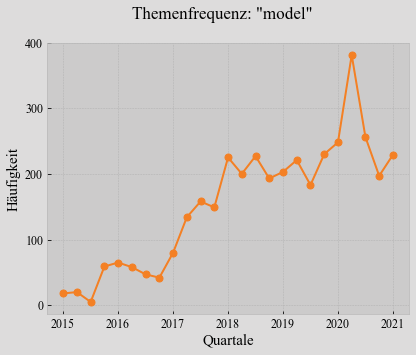

In [17]:
topic = "model"
topic_name = "model"

y_values = get_y_values(topic)
draw_plot(y_values, topic_name)

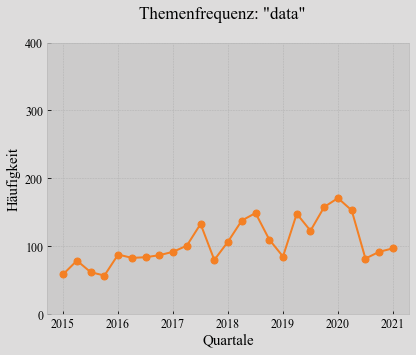

In [18]:
topic = "datum"
topic_name = "data"

y_values = get_y_values(topic)
draw_plot(y_values, topic_name)

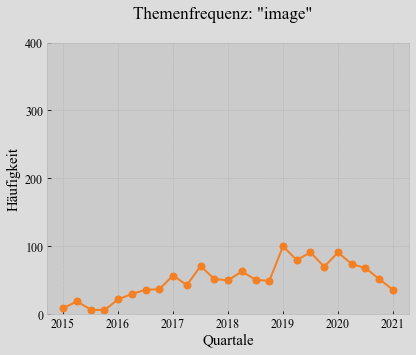

In [19]:
topic = "image"
topic_name = "image"

y_values = get_y_values(topic)
draw_plot(y_values, topic_name)

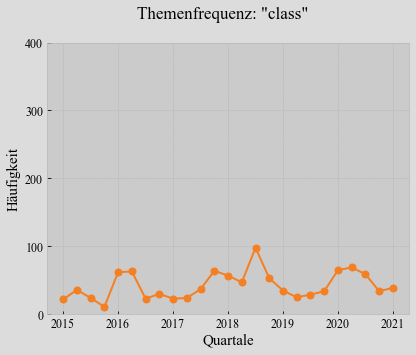

In [20]:
topic = "class"
topic_name = "class"

y_values = get_y_values(topic)
draw_plot(y_values, topic_name)

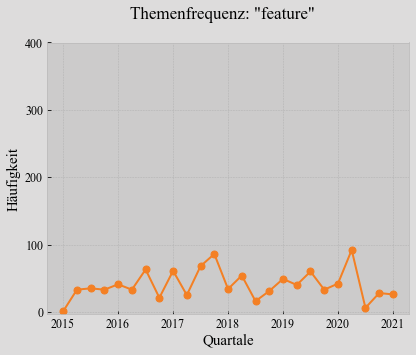

In [21]:
topic = "feature"
topic_name = "feature"

y_values = get_y_values(topic)
draw_plot(y_values, topic_name)

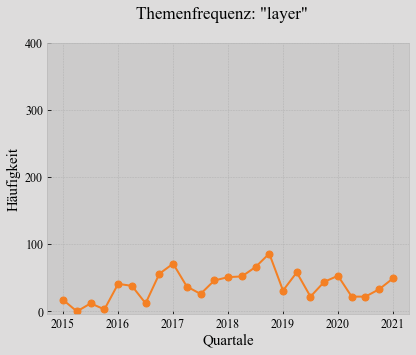

In [22]:
topic = "layer"
topic_name = "layer"

y_values = get_y_values(topic)
draw_plot(y_values, topic_name)

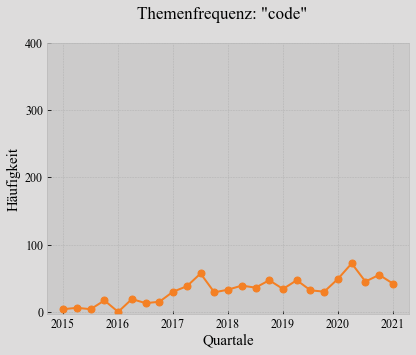

In [23]:
topic = "code"
topic_name = "code"

y_values = get_y_values(topic)
draw_plot(y_values, topic_name)

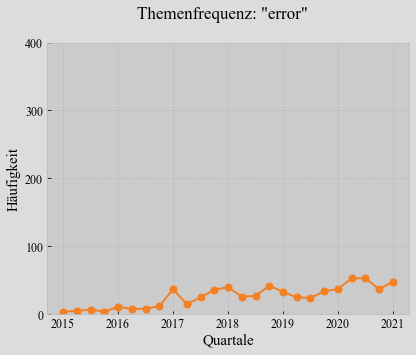

In [24]:
topic = "error"
topic_name = "error"

y_values = get_y_values(topic)
draw_plot(y_values, topic_name)

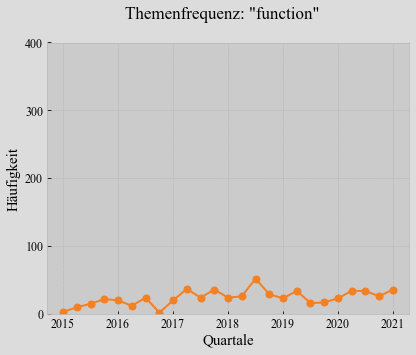

In [25]:
topic = "function"
topic_name = "function"

y_values = get_y_values(topic)
draw_plot(y_values, topic_name)

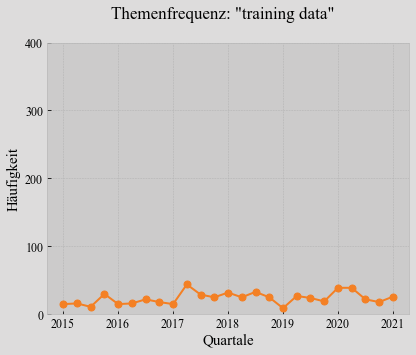

In [27]:
topic = "training datum"
topic_name = "training data"

y_values = get_y_values(topic)
draw_plot(y_values, topic_name)